In [4]:
import numpy as np
import json
from pprint import pprint
import matplotlib.pyplot as plt
from collections import defaultdict

plt.rcParams['figure.figsize'] = [16, 72]

In [5]:
#Opening the experiment json
def load_probe_metric_list(fname,only_last=False):
    with open(fname,"r") as rhandle:
        probe_metric_list = json.load(rhandle)
    
    #Converting the metric into usable format
    pdict = defaultdict(list)
    
    #Getting only the final outcome if only_last required
    if only_last==True:
        probe_metric_list = probe_metric_list[-1:]#[-10:-9]
    
    for idx in range(len(probe_metric_list)):
        pdict["angle:m-t0"].append(probe_metric_list[idx]["conv_angle_dict"]["main"]["topic0"])
        pdict["angle:m-t1"].append(probe_metric_list[idx]["conv_angle_dict"]["main"]["topic1"])
        pdict["angle:t0-t1"].append(probe_metric_list[idx]["conv_angle_dict"]["topic0"]["topic1"])
        pdict["acc:main"].append(probe_metric_list[idx]["classifier_acc_dict"]["main"])
        pdict["acc:topic0"].append(probe_metric_list[idx]["classifier_acc_dict"]["topic0"])
        pdict["topic0_main"].append(probe_metric_list[idx]["classifier_acc_dict"]["topic0_flip_main"])
        pdict["topic0_pdelta"].append(probe_metric_list[idx]["classifier_acc_dict"]["topic0_flip_main_pdelta"])
        pdict["acc:topic1"].append(probe_metric_list[idx]["classifier_acc_dict"]["topic1"])
        pdict["topic1_main"].append(probe_metric_list[idx]["classifier_acc_dict"]["topic1_flip_main"])
        pdict["topic1_pdelta"].append(probe_metric_list[idx]["classifier_acc_dict"]["topic1_flip_main_pdelta"])
        if "topic1_flip_emb_diff" in probe_metric_list[idx]["classifier_acc_dict"]:
            pdict["topic1_emb_diff"].append(probe_metric_list[idx]["classifier_acc_dict"]["topic1_flip_emb_diff"])
            pdict["topic0_emb_diff"].append(probe_metric_list[idx]["classifier_acc_dict"]["topic0_flip_emb_diff"])
        if "topic1_flip_main_logpdelta" in probe_metric_list[idx]["classifier_acc_dict"]:
            pdict["topic0_logpdelta"].append(probe_metric_list[idx]["classifier_acc_dict"]["topic0_flip_main_logpdelta"])
            pdict["topic1_logpdelta"].append(probe_metric_list[idx]["classifier_acc_dict"]["topic1_flip_main_logpdelta"])
    return pdict

In [6]:
#Collecting multiple runs of experiment
def aggregate_random_runs(rdict_list):
    '''
    '''
    #This is done assuming we have only one value per rdict i.e after convergence.
    rdict_agg_list = defaultdict(list)
    for rdict in rdict_list:
        for key,val in rdict.items():
            rdict_agg_list[key]+=val
    
    #Now taking the mean of the experiments
    rdict_agg = defaultdict(list)
    for key,val in rdict_agg_list.items():
        rdict_agg[key] = dict(
                            mean = np.mean(val),
                            std  = np.std(val)
        )
    
    return rdict_agg

def get_all_result_dict(run_list,pval_list,fname_pattern):
    all_result_dict = {}
    for pidx,pval in enumerate(pval_list):
        prdict_list = []
        for nidx in run_list:
            fname = fname_pattern.format(pval,nidx)
            prdict = load_probe_metric_list(fname,only_last=True)
            prdict_list.append(prdict)
        #Getting the aggregate result
        prdict_agg = aggregate_random_runs(prdict_list)
        all_result_dict[pval] = prdict_agg

    return all_result_dict

def get_all_result_timeline(run_num,pval_list,fname_pattern):
    all_result_timeline={}
    for pval in pval_list:
        fname = fname_pattern.format(pval,run_num)
        prdict = load_probe_metric_list(fname)
        all_result_timeline[pval] = prdict
    return all_result_timeline

def plot_all_results(ax,pval_list,all_result_dict,plot_item_list,extra_label=""):
    '''
    '''
    #Now we can reuse the previous ax
    if(type(ax)!=type(np.array([1,2]))):
        fig,ax = plt.subplots(len(plot_item_list),)
        
    for iidx,item_name in enumerate(plot_item_list):
        #Colletcing the metrics
        yval = [all_result_dict[pval][item_name]["mean"] for pval in pval_list]
        yerr = [all_result_dict[pval][item_name]["std"] for pval in pval_list]
        #Plotting the guy
        ax[iidx].errorbar(pval_list,yval,yerr,ls="-.",marker="o",label=item_name+extra_label)
#         ax[iidx].set_ylim(0.0,1.0)
        ax[iidx].set_xlabel("correlation value [0.5,1]")
        ax[iidx].set_ylabel("result")
        ax[iidx].legend()
        ax[iidx].grid(True)
        ax[iidx].set_title(item_name)
    return ax



def plot_one_timeline(pval_list,all_result_timeline,plot_item_list):
    fig,ax = plt.subplots(len(plot_item_list),)
    
    for pval in pval_list:
        pdict_timeline = all_result_timeline[pval]
        for iidx,item_name in enumerate(plot_item_list):
            x_val = range(len(pdict_timeline[item_name])) #Denotes the number of epoch
            y_val = pdict_timeline[item_name]
            ax[iidx].plot(x_val,y_val,marker="o",ls="-.",label="pval={}".format(pval))
            ax[iidx].set_xlabel("epochs")
            ax[iidx].set_ylabel("value")
            ax[iidx].legend()
            ax[iidx].grid(True)
            ax[iidx].set_title(item_name)
    plt.show()

# Timelines

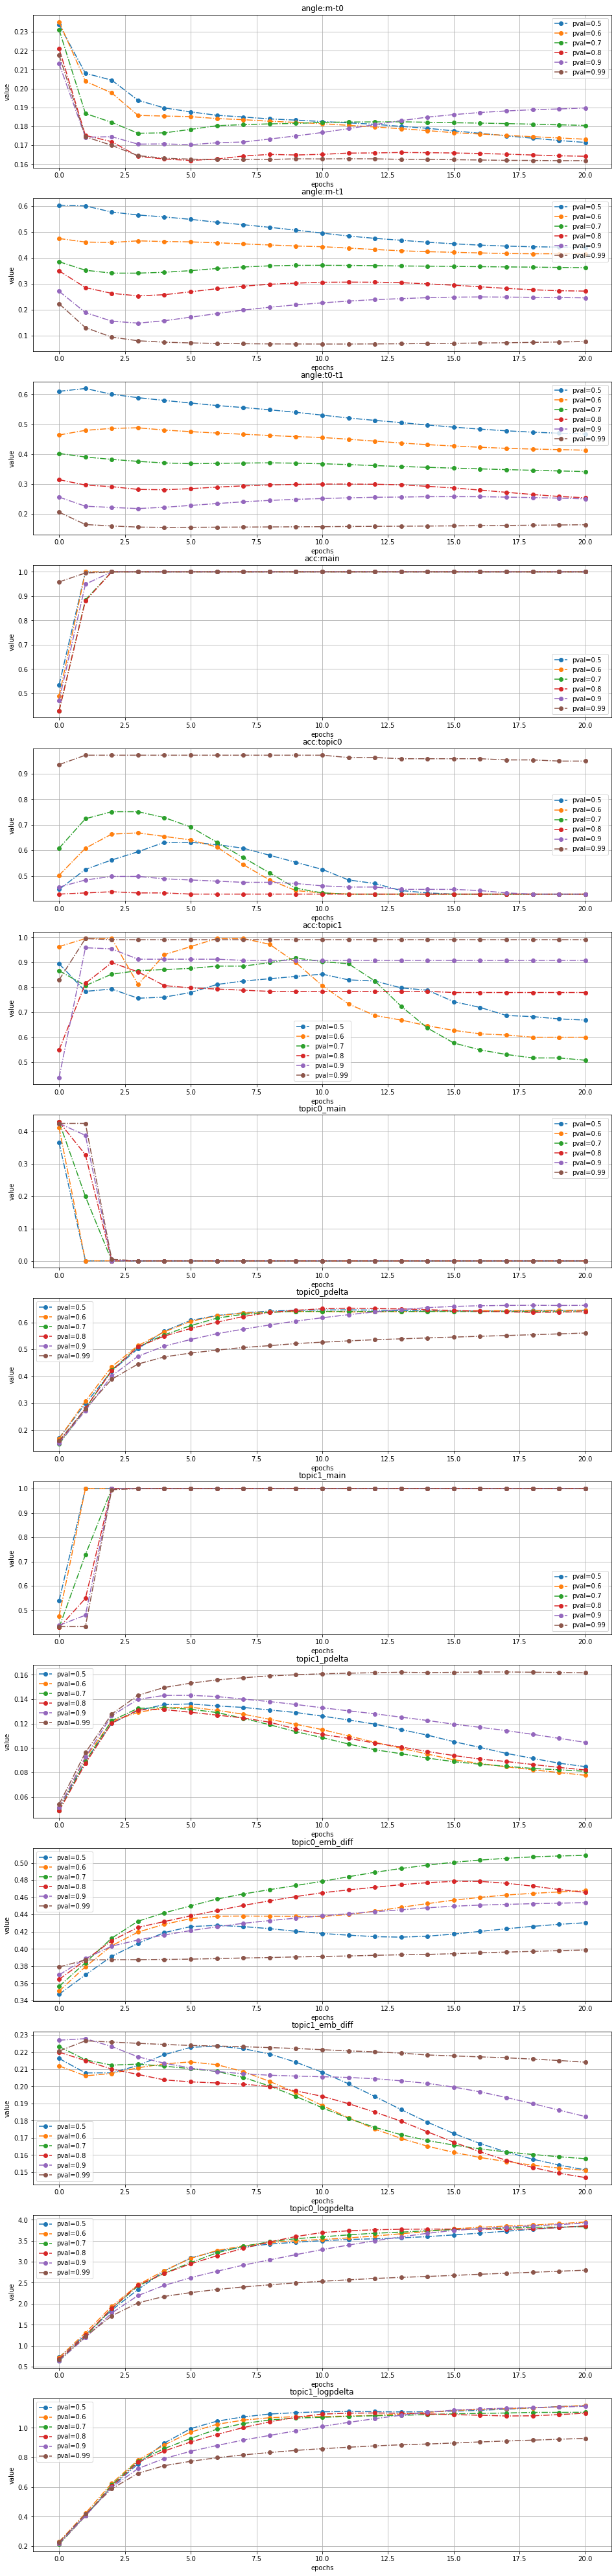

In [21]:
run_num=0
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99]
loss_type="linear_svm"
remmode="adversarial"
grstrength=1
advepoch=20
l2_lambda="0.00001"
hretrain="no_warm_encoder"
mainmode="non_causal"
noise=0.0
hlayer=0
sample=500
mainepoch=1
plot_item_list = [
                    "angle:m-t0",
                    "angle:m-t1",
                    "angle:t0-t1",
                    "acc:main",
                    "acc:topic0",
                    "acc:topic1",
                    "topic0_main",
                    "topic0_pdelta",
                    "topic1_main",
                    "topic1_pdelta",
                    "topic0_emb_diff",
                    "topic1_emb_diff",
                    "topic0_logpdelta",
                    "topic1_logpdelta",
]
fname_pattern="nlp_logs/pt.rel.remmode({}).grstrength({}).advepoch({}).lt({}).l2({}).hretrain({}).mainmode({}).noise({}).hlayer({}).sample({}).mainepoch({}).p({}).run({})/probe_metric_list.json".format(
                                                                                  remmode,
                                                                                  grstrength,
                                                                                  advepoch,
                                                                                  loss_type,
                                                                                  l2_lambda,
                                                                                  hretrain,
                                                                                  mainmode,
                                                                                  noise,
                                                                                  hlayer,
                                                                                  sample,
                                                                                  mainepoch,
                                                                                  "{}",
                                                                                  "{}",
)
all_result_timeline = get_all_result_timeline(run_num,pval_list,fname_pattern)
plot_one_timeline(pval_list,all_result_timeline,plot_item_list)

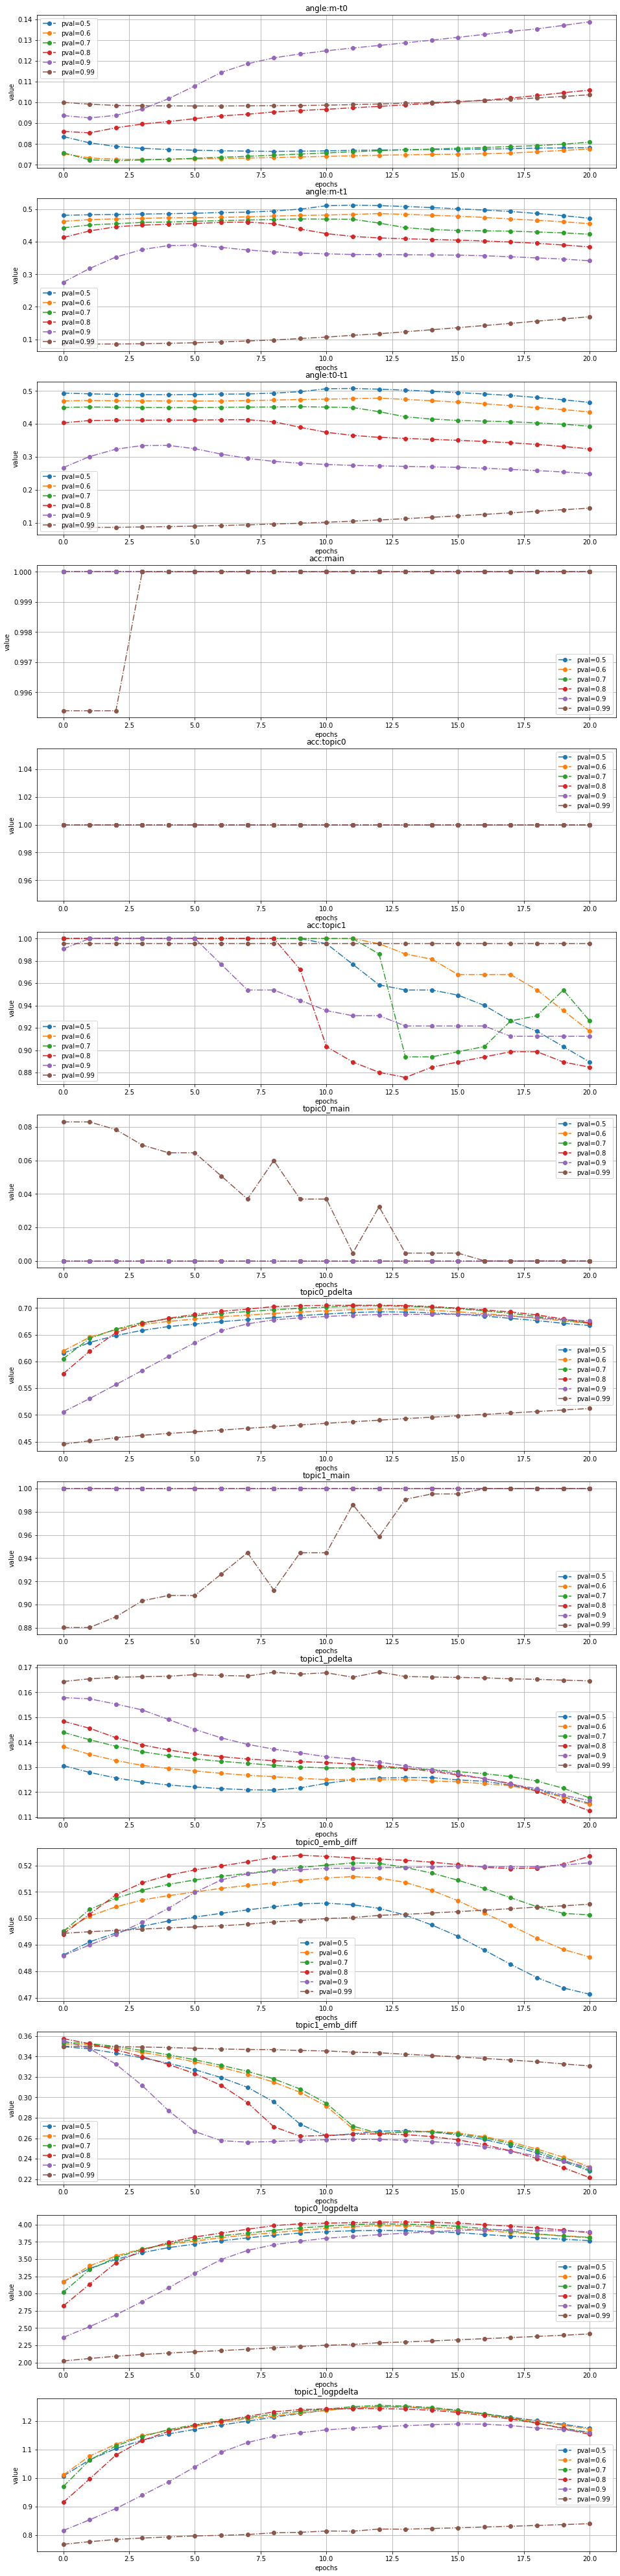

In [19]:
run_num=0
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99]
loss_type="linear_svm"
remmode="adversarial"
grstrength=1
advepoch=20
l2_lambda="0.00001"
hretrain="no_warm_encoder"
mainmode="non_causal"
noise=0.0
hlayer=0
sample=500
mainepoch=5
plot_item_list = [
                    "angle:m-t0",
                    "angle:m-t1",
                    "angle:t0-t1",
                    "acc:main",
                    "acc:topic0",
                    "acc:topic1",
                    "topic0_main",
                    "topic0_pdelta",
                    "topic1_main",
                    "topic1_pdelta",
                    "topic0_emb_diff",
                    "topic1_emb_diff",
                    "topic0_logpdelta",
                    "topic1_logpdelta",
]
fname_pattern="nlp_logs/pt.rel.remmode({}).grstrength({}).advepoch({}).lt({}).l2({}).hretrain({}).mainmode({}).noise({}).hlayer({}).sample({}).mainepoch({}).p({}).run({})/probe_metric_list.json".format(
                                                                                  remmode,
                                                                                  grstrength,
                                                                                  advepoch,
                                                                                  loss_type,
                                                                                  l2_lambda,
                                                                                  hretrain,
                                                                                  mainmode,
                                                                                  noise,
                                                                                  hlayer,
                                                                                  sample,
                                                                                  mainepoch,
                                                                                  "{}",
                                                                                  "{}",
)
all_result_timeline = get_all_result_timeline(run_num,pval_list,fname_pattern)
plot_one_timeline(pval_list,all_result_timeline,plot_item_list)

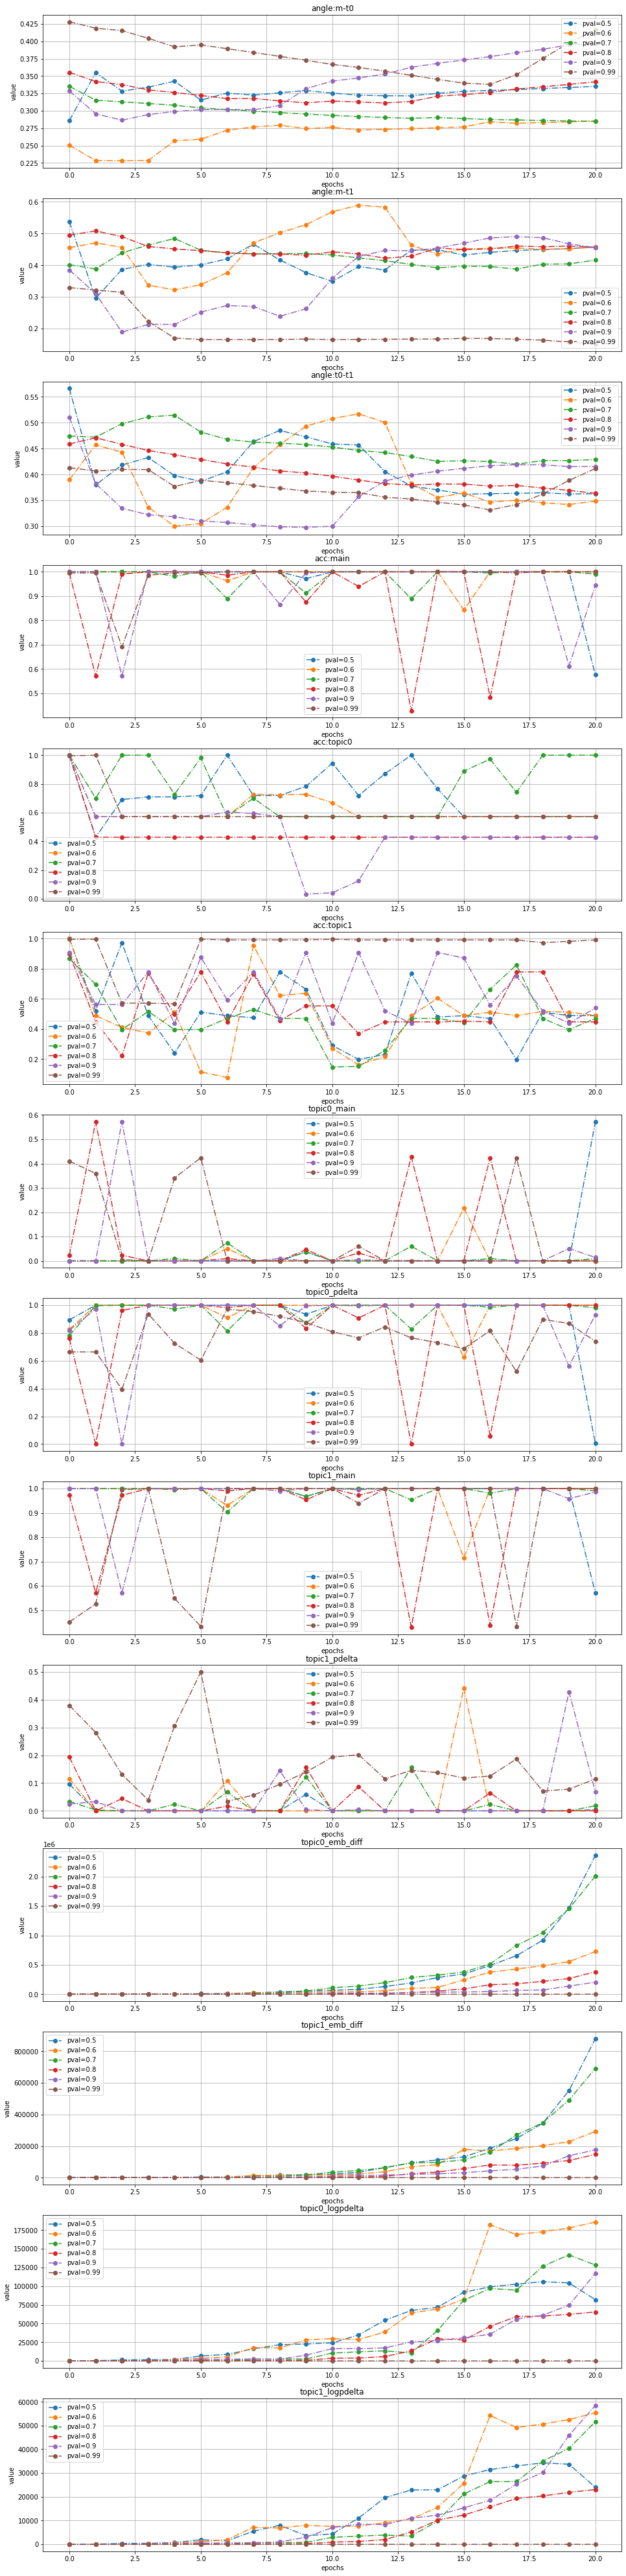

In [25]:
run_num=0
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99]
loss_type="linear_svm"
remmode="adversarial"
grstrength=1
advepoch=20
l2_lambda="0.001"
hretrain="no_warm_encoder"
mainmode="non_causal"
noise=0.0
hlayer=4
sample=500
mainepoch=1
plot_item_list = [
                    "angle:m-t0",
                    "angle:m-t1",
                    "angle:t0-t1",
                    "acc:main",
                    "acc:topic0",
                    "acc:topic1",
                    "topic0_main",
                    "topic0_pdelta",
                    "topic1_main",
                    "topic1_pdelta",
                    "topic0_emb_diff",
                    "topic1_emb_diff",
                    "topic0_logpdelta",
                    "topic1_logpdelta",
]
fname_pattern="nlp_logs/pt.rel.remmode({}).grstrength({}).advepoch({}).lt({}).l2({}).hretrain({}).mainmode({}).noise({}).hlayer({}).sample({}).mainepoch({}).p({}).run({})/probe_metric_list.json".format(
                                                                                  remmode,
                                                                                  grstrength,
                                                                                  advepoch,
                                                                                  loss_type,
                                                                                  l2_lambda,
                                                                                  hretrain,
                                                                                  mainmode,
                                                                                  noise,
                                                                                  hlayer,
                                                                                  sample,
                                                                                  mainepoch,
                                                                                  "{}",
                                                                                  "{}",
)
all_result_timeline = get_all_result_timeline(run_num,pval_list,fname_pattern)
plot_one_timeline(pval_list,all_result_timeline,plot_item_list)

# Variation with Regularization

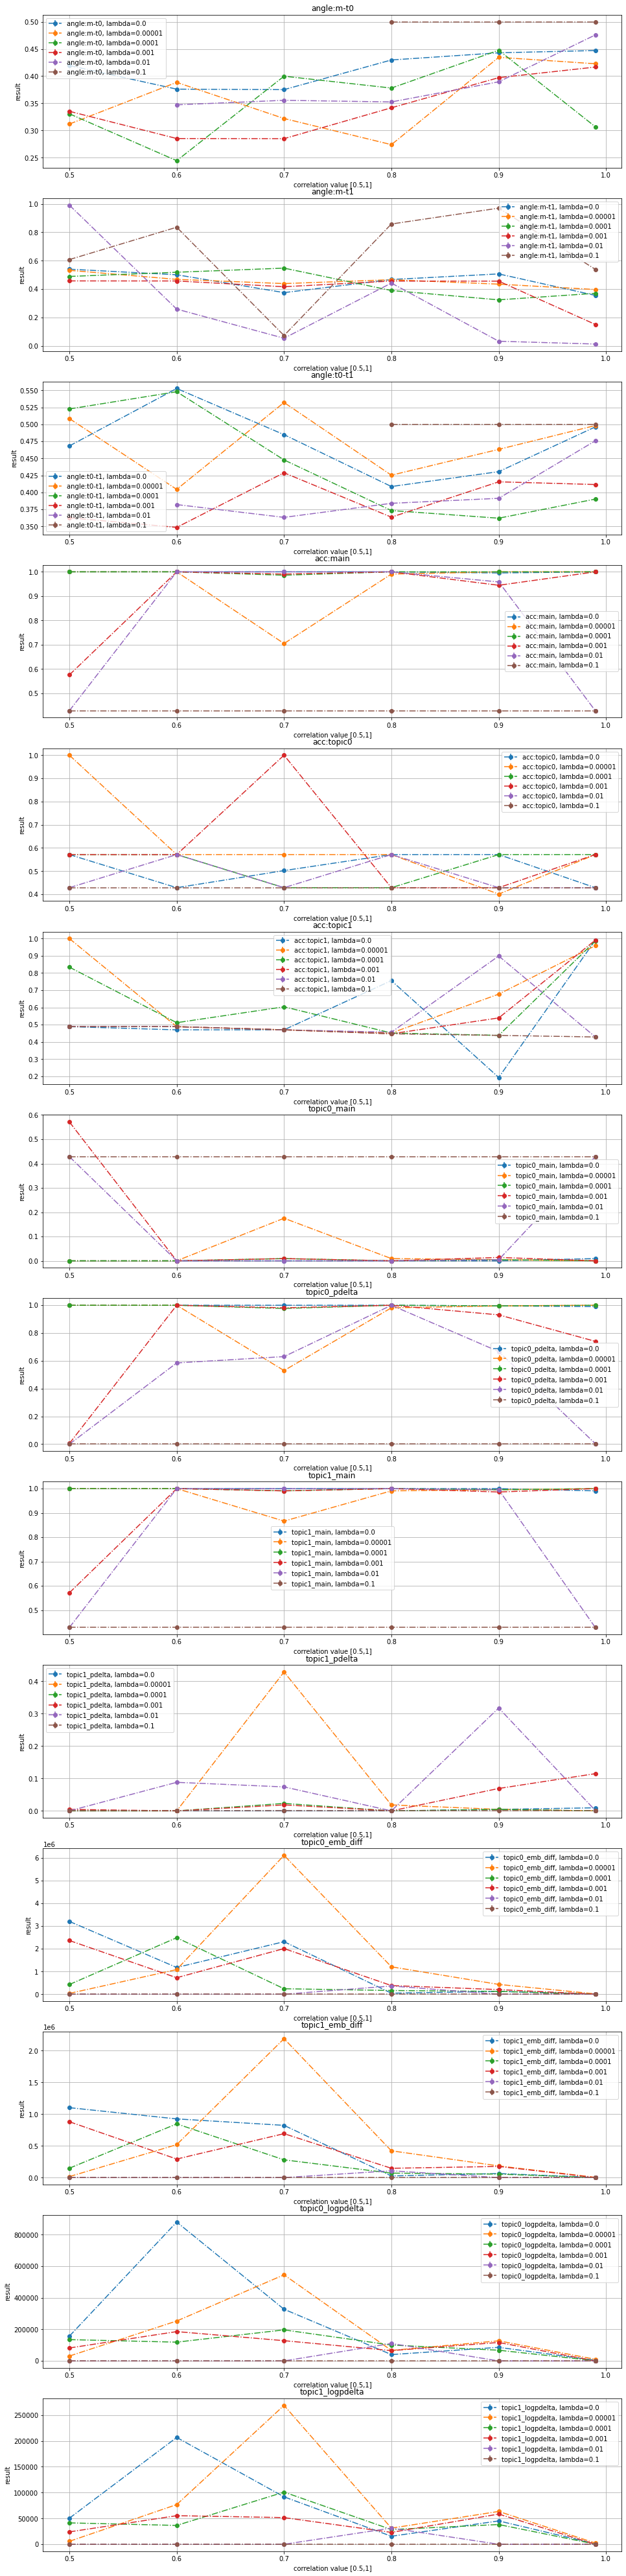

'\nHere we should choose h and lambda combination which is best for the model and see the trend.\n'

In [8]:
#Getting the result for different epochs
run_list=[0,]
plot_item_list = [
                    "angle:m-t0",
                    "angle:m-t1",
                    "angle:t0-t1",
                    "acc:main",
                    "acc:topic0",
                    "acc:topic1",
                    "topic0_main",
                    "topic0_pdelta",
                    "topic1_main",
                    "topic1_pdelta",
                    "topic0_emb_diff",
                    "topic1_emb_diff",
                    "topic0_logpdelta",
                    "topic1_logpdelta",
]


ax=None

#Other hyperparam
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99]
loss_type="linear_svm"
remmode="adversarial"
grstrength=1
advepoch=20
l2_lambda="0.00001"
hretrain="no_warm_encoder"
mainmode="non_causal"
noise=0.0
hlayer=4 #0,1,2,4
sample=500
mainepoch=1
for l2_lambda in ["0.0","0.00001","0.0001","0.001","0.01","0.1"]:
    all_result_dict = get_all_result_dict(run_list=run_list,
                                          pval_list=pval_list,
                                          fname_pattern="nlp_logs/pt.rel.remmode({}).grstrength({}).advepoch({}).lt({}).l2({}).hretrain({}).mainmode({}).noise({}).hlayer({}).sample({}).mainepoch({}).p({}).run({})/probe_metric_list.json".format(
                                                                                  remmode,
                                                                                  grstrength,
                                                                                  advepoch,
                                                                                  loss_type,
                                                                                  l2_lambda,
                                                                                  hretrain,
                                                                                  mainmode,
                                                                                  noise,
                                                                                  hlayer,
                                                                                  sample,
                                                                                  mainepoch,
                                                                                  "{}",
                                                                                  "{}",
                                                            )
    )
#     print(all_result_dict)
    ax = plot_all_results(ax,pval_list,all_result_dict,plot_item_list,extra_label=", lambda={}".format(l2_lambda))


plt.show()
'''
Here we should choose h and lambda combination which is best for the model and see the trend.
'''

# Getting the Sample Variation

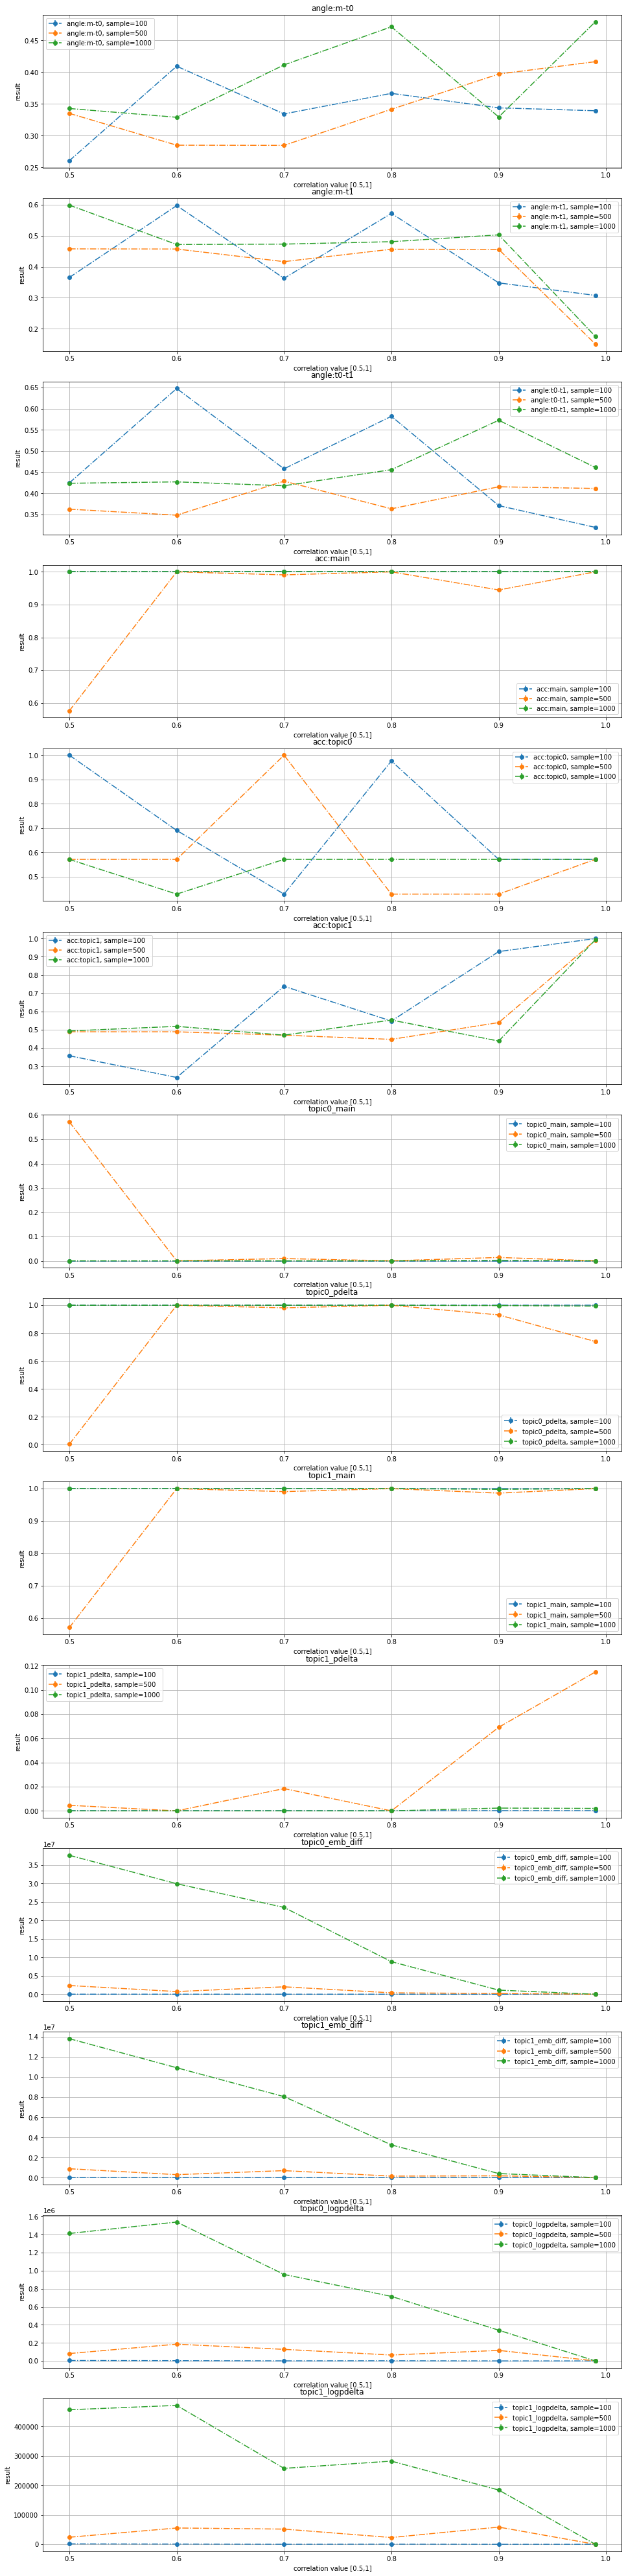

'\nHere we should choose h and lambda combination which is best for the model and see the trend.\n'

In [26]:
#Getting the result for different epochs
run_list=[0,]
plot_item_list = [
                    "angle:m-t0",
                    "angle:m-t1",
                    "angle:t0-t1",
                    "acc:main",
                    "acc:topic0",
                    "acc:topic1",
                    "topic0_main",
                    "topic0_pdelta",
                    "topic1_main",
                    "topic1_pdelta",
                    "topic0_emb_diff",
                    "topic1_emb_diff",
                    "topic0_logpdelta",
                    "topic1_logpdelta",
]


ax=None

#Other hyperparam
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99]
loss_type="linear_svm"
remmode="adversarial"
grstrength=1
advepoch=20
hretrain="no_warm_encoder"
mainmode="non_causal"
noise=0.0
hlayer=4
l2_lambda="0.001"
sample=500
mainepoch=1
#0,0.01 1,0.01 2,0.001 4,0.001
for sample in [100,500,1000]:
    all_result_dict = get_all_result_dict(run_list=run_list,
                                          pval_list=pval_list,
                                          fname_pattern="nlp_logs/pt.rel.remmode({}).grstrength({}).advepoch({}).lt({}).l2({}).hretrain({}).mainmode({}).noise({}).hlayer({}).sample({}).mainepoch({}).p({}).run({})/probe_metric_list.json".format(
                                                                                  remmode,
                                                                                  grstrength,
                                                                                  advepoch,
                                                                                  loss_type,
                                                                                  l2_lambda,
                                                                                  hretrain,
                                                                                  mainmode,
                                                                                  noise,
                                                                                  hlayer,
                                                                                  sample,
                                                                                  mainepoch,
                                                                                  "{}",
                                                                                  "{}",
                                                            )
    )
#     print(all_result_dict)
    ax = plot_all_results(ax,pval_list,all_result_dict,plot_item_list,extra_label=", sample={}".format(sample))


plt.show()
'''
Here we should choose h and lambda combination which is best for the model and see the trend.
'''

# Varitaion with number of noise

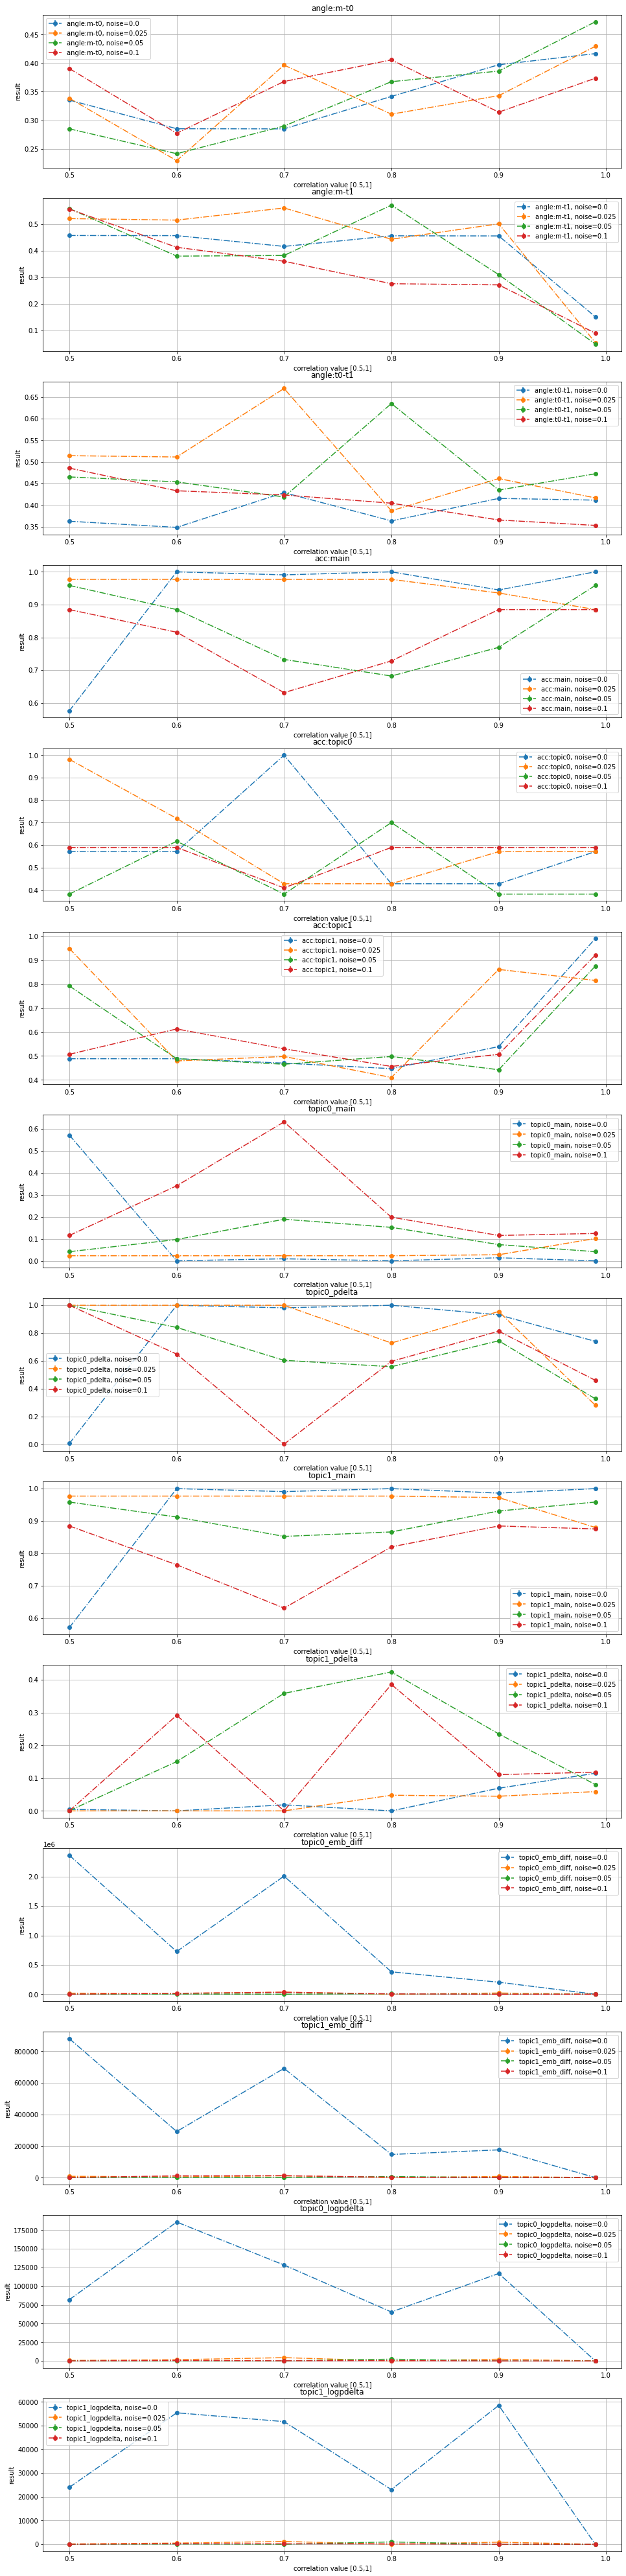

'\nHere we should choose h and lambda combination which is best for the model and see the trend.\n'

In [27]:
#Getting the result for different epochs
run_list=[0,]
plot_item_list = [
                    "angle:m-t0",
                    "angle:m-t1",
                    "angle:t0-t1",
                    "acc:main",
                    "acc:topic0",
                    "acc:topic1",
                    "topic0_main",
                    "topic0_pdelta",
                    "topic1_main",
                    "topic1_pdelta",
                    "topic0_emb_diff",
                    "topic1_emb_diff",
                    "topic0_logpdelta",
                    "topic1_logpdelta",
]


ax=None

#Other hyperparam
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99]
loss_type="linear_svm"
remmode="adversarial"
grstrength=1
advepoch=20
hretrain="no_warm_encoder"
mainmode="non_causal"
noise=0.0
hlayer=4
l2_lambda="0.001"
sample=500
mainepoch=1
#0,0.01 1,0.01 2,0.001 4,0.001
for noise in [0.0,0.025,0.05,0.1]:
    all_result_dict = get_all_result_dict(run_list=run_list,
                                          pval_list=pval_list,
                                          fname_pattern="nlp_logs/pt.rel.remmode({}).grstrength({}).advepoch({}).lt({}).l2({}).hretrain({}).mainmode({}).noise({}).hlayer({}).sample({}).mainepoch({}).p({}).run({})/probe_metric_list.json".format(
                                                                                  remmode,
                                                                                  grstrength,
                                                                                  advepoch,
                                                                                  loss_type,
                                                                                  l2_lambda,
                                                                                  hretrain,
                                                                                  mainmode,
                                                                                  noise,
                                                                                  hlayer,
                                                                                  sample,
                                                                                  mainepoch,
                                                                                  "{}",
                                                                                  "{}",
                                                            )
    )
#     print(all_result_dict)
    ax = plot_all_results(ax,pval_list,all_result_dict,plot_item_list,extra_label=", noise={}".format(noise))


plt.show()
'''
Here we should choose h and lambda combination which is best for the model and see the trend.
'''

# Variation with removal epoch

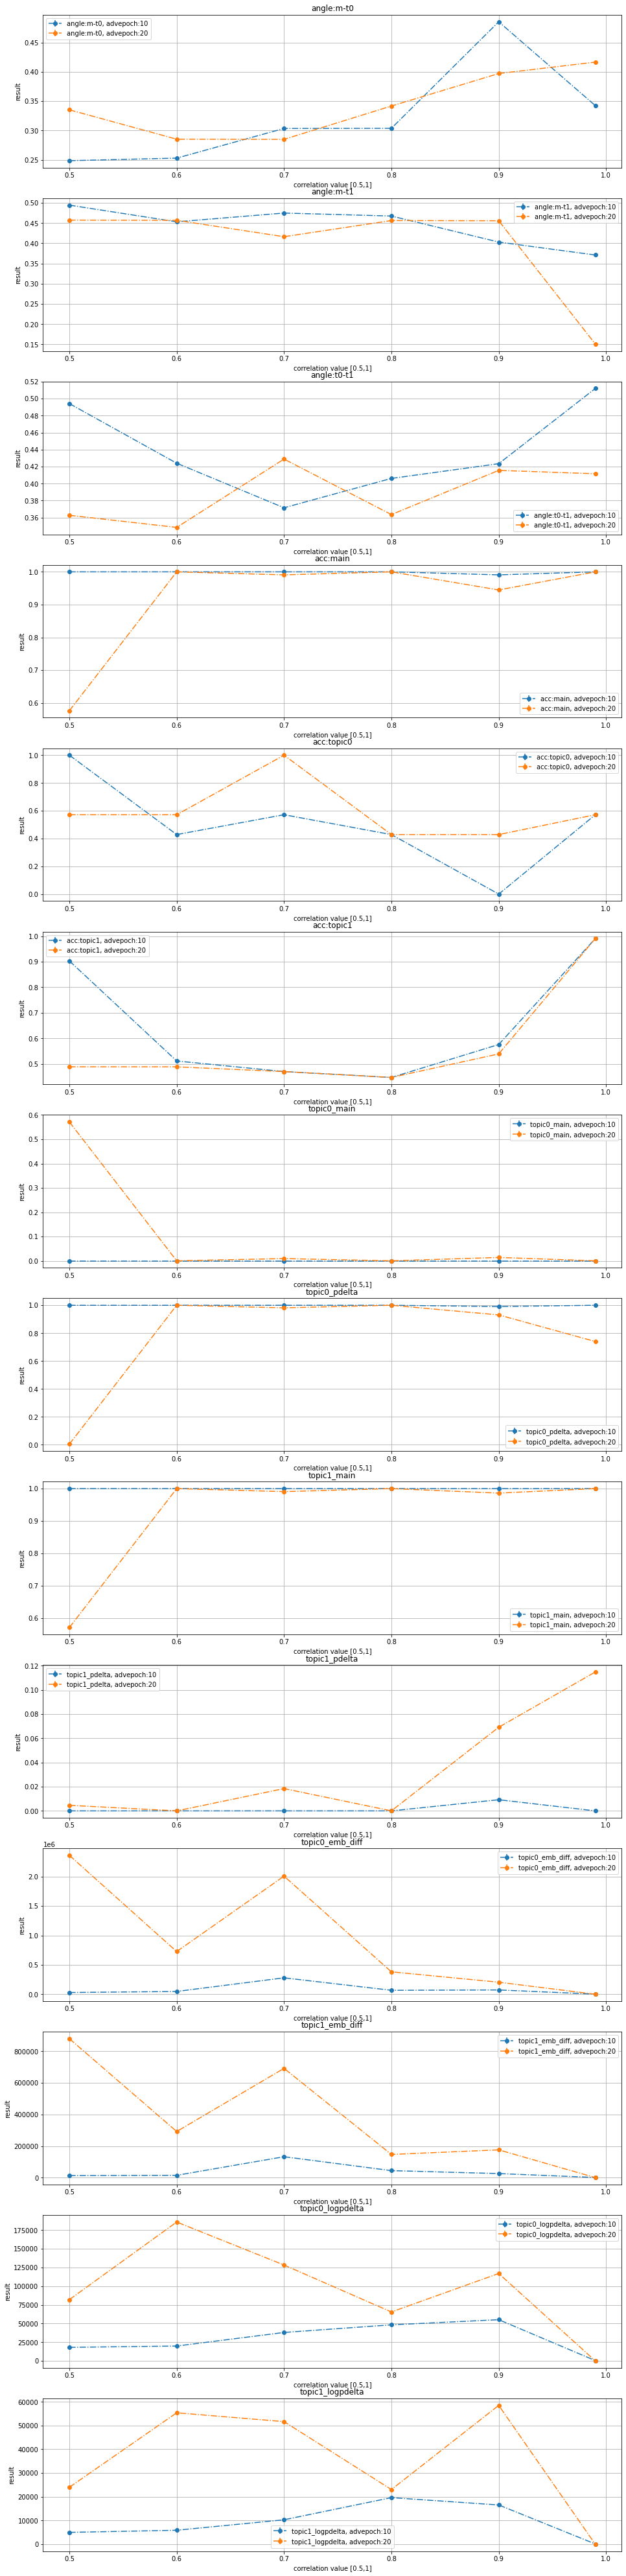

'\nHere we should choose h and lambda combination which is best for the model and see the trend.\n'

In [29]:
#Getting the result for different epochs
run_list=[0,]
plot_item_list = [
                    "angle:m-t0",
                    "angle:m-t1",
                    "angle:t0-t1",
                    "acc:main",
                    "acc:topic0",
                    "acc:topic1",
                    "topic0_main",
                    "topic0_pdelta",
                    "topic1_main",
                    "topic1_pdelta",
                    "topic0_emb_diff",
                    "topic1_emb_diff",
                    "topic0_logpdelta",
                    "topic1_logpdelta",
]


ax=None

#Other hyperparam
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99]
loss_type="linear_svm"
remmode="adversarial"
grstrength=1
advepoch=20
hretrain="no_warm_encoder"
mainmode="non_causal"
noise=0.0
hlayer=4
l2_lambda="0.001"
sample=500
mainepoch=1
for advepoch in [10,20]:
    all_result_dict = get_all_result_dict(run_list=run_list,
                                          pval_list=pval_list,
                                          fname_pattern="nlp_logs/pt.rel.remmode({}).grstrength({}).advepoch({}).lt({}).l2({}).hretrain({}).mainmode({}).noise({}).hlayer({}).sample({}).mainepoch({}).p({}).run({})/probe_metric_list.json".format(
                                                                                  remmode,
                                                                                  grstrength,
                                                                                  advepoch,
                                                                                  loss_type,
                                                                                  l2_lambda,
                                                                                  hretrain,
                                                                                  mainmode,
                                                                                  noise,
                                                                                  hlayer,
                                                                                  sample,
                                                                                  mainepoch,
                                                                                  "{}",
                                                                                  "{}",
                                                            )
    )
#     print(all_result_dict)
    ax = plot_all_results(ax,pval_list,all_result_dict,plot_item_list,extra_label=", advepoch:{}".format(advepoch))


plt.show()
'''
Here we should choose h and lambda combination which is best for the model and see the trend.
'''

# Variation with removal reversal strength

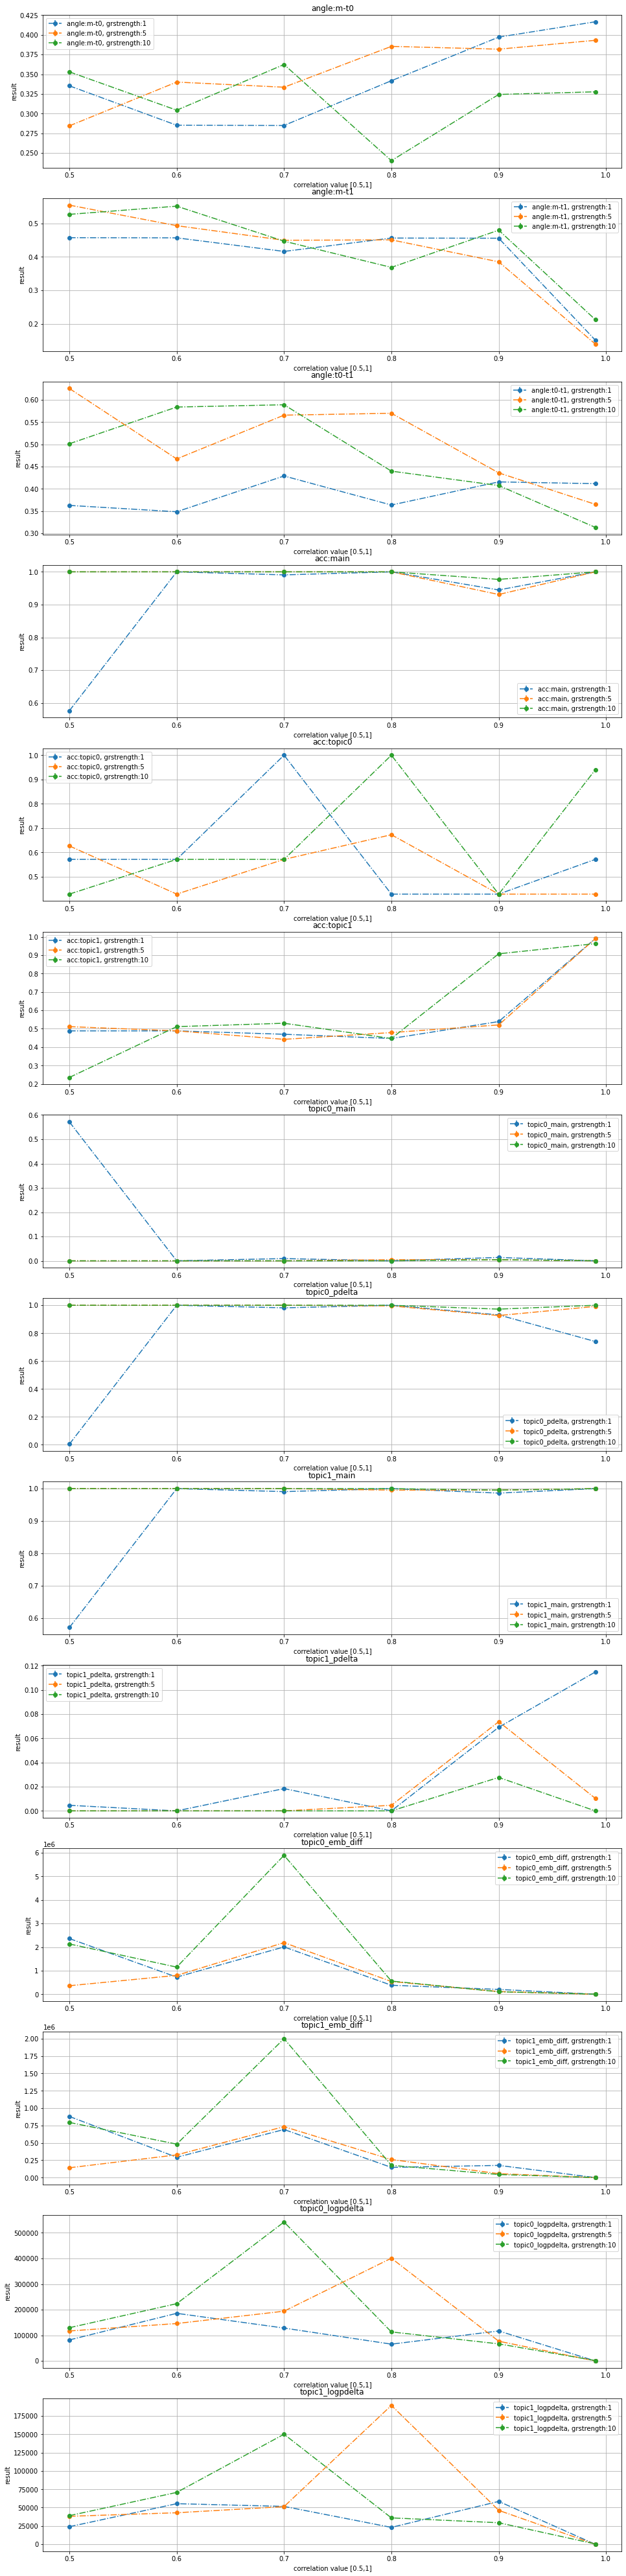

'\nHere we should choose h and lambda combination which is best for the model and see the trend.\n'

In [30]:
#Getting the result for different epochs
run_list=[0,]
plot_item_list = [
                    "angle:m-t0",
                    "angle:m-t1",
                    "angle:t0-t1",
                    "acc:main",
                    "acc:topic0",
                    "acc:topic1",
                    "topic0_main",
                    "topic0_pdelta",
                    "topic1_main",
                    "topic1_pdelta",
                    "topic0_emb_diff",
                    "topic1_emb_diff",
                    "topic0_logpdelta",
                    "topic1_logpdelta",
]


ax=None

#Other hyperparam
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99]
loss_type="linear_svm"
remmode="adversarial"
grstrength=1
advepoch=20
hretrain="no_warm_encoder"
mainmode="non_causal"
noise=0.0
hlayer=4
l2_lambda="0.001"
sample=500
mainepoch=1
for grstrength in [1,5,10]:
    all_result_dict = get_all_result_dict(run_list=run_list,
                                          pval_list=pval_list,
                                          fname_pattern="nlp_logs/pt.rel.remmode({}).grstrength({}).advepoch({}).lt({}).l2({}).hretrain({}).mainmode({}).noise({}).hlayer({}).sample({}).mainepoch({}).p({}).run({})/probe_metric_list.json".format(
                                                                                  remmode,
                                                                                  grstrength,
                                                                                  advepoch,
                                                                                  loss_type,
                                                                                  l2_lambda,
                                                                                  hretrain,
                                                                                  mainmode,
                                                                                  noise,
                                                                                  hlayer,
                                                                                  sample,
                                                                                  mainepoch,
                                                                                  "{}",
                                                                                  "{}",
                                                            )
    )
#     print(all_result_dict)
    ax = plot_all_results(ax,pval_list,all_result_dict,plot_item_list,extra_label=", grstrength:{}".format(grstrength))


plt.show()
'''
Here we should choose h and lambda combination which is best for the model and see the trend.
'''

## Variation with main epoch

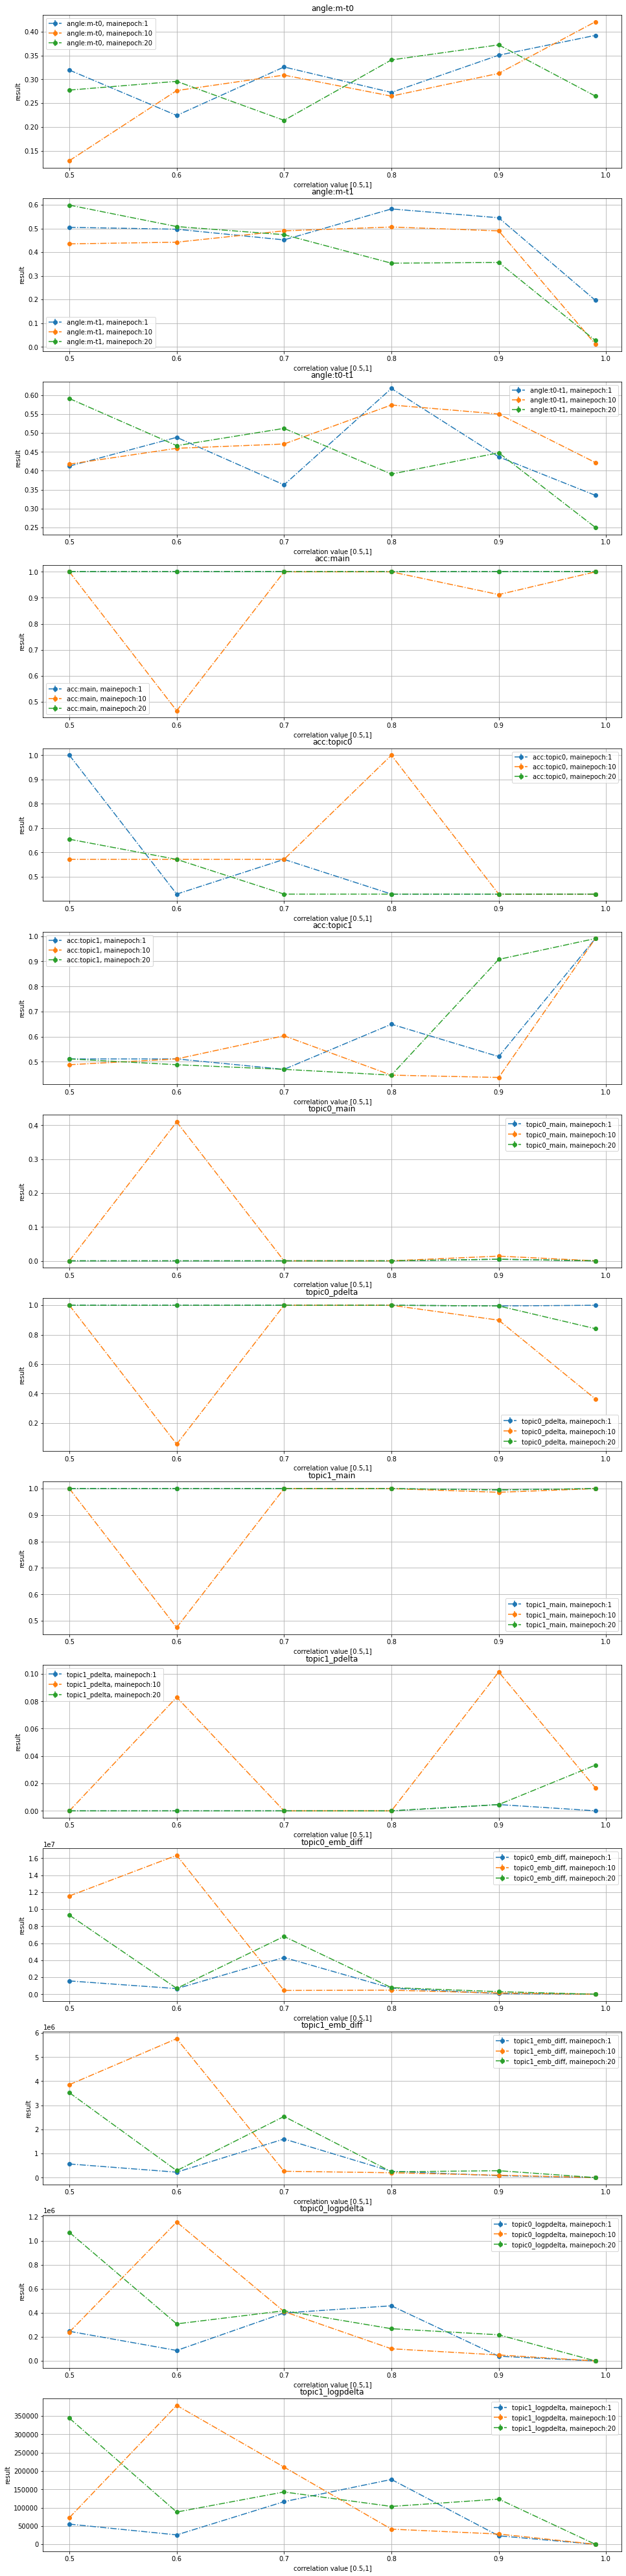

'\nHere we should choose h and lambda combination which is best for the model and see the trend.\n'

In [19]:
#Getting the result for different epochs
run_list=[0,]
plot_item_list = [
                    "angle:m-t0",
                    "angle:m-t1",
                    "angle:t0-t1",
                    "acc:main",
                    "acc:topic0",
                    "acc:topic1",
                    "topic0_main",
                    "topic0_pdelta",
                    "topic1_main",
                    "topic1_pdelta",
                    "topic0_emb_diff",
                    "topic1_emb_diff",
                    "topic0_logpdelta",
                    "topic1_logpdelta",
]


ax=None

#Other hyperparam
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99]
loss_type="linear_svm"
remmode="adversarial"
grstrength=1
advepoch=20
hretrain="no_warm_encoder"
mainmode="non_causal"
noise=0.0
#0,0.01 1,0.01 2,0.001 4,0.001
hlayer=4
l2_lambda="0.001"
sample=500
mainepoch=1
for mainepoch in [1,10,20]:
    all_result_dict = get_all_result_dict(run_list=run_list,
                                          pval_list=pval_list,
                                          fname_pattern="nlp_logs/pt.rel.remmode({}).grstrength({}).advepoch({}).lt({}).l2({}).hretrain({}).mainmode({}).noise({}).hlayer({}).sample({}).mainepoch({}).p({}).run({})/probe_metric_list.json".format(
                                                                                  remmode,
                                                                                  grstrength,
                                                                                  advepoch,
                                                                                  loss_type,
                                                                                  l2_lambda,
                                                                                  hretrain,
                                                                                  mainmode,
                                                                                  noise,
                                                                                  hlayer,
                                                                                  sample,
                                                                                  mainepoch,
                                                                                  "{}",
                                                                                  "{}",
                                                            )
    )
#     print(all_result_dict)
    ax = plot_all_results(ax,pval_list,all_result_dict,plot_item_list,extra_label=", mainepoch:{}".format(mainepoch))


plt.show()
'''
Here we should choose h and lambda combination which is best for the model and see the trend.
'''

# Testing the variation with layers separately

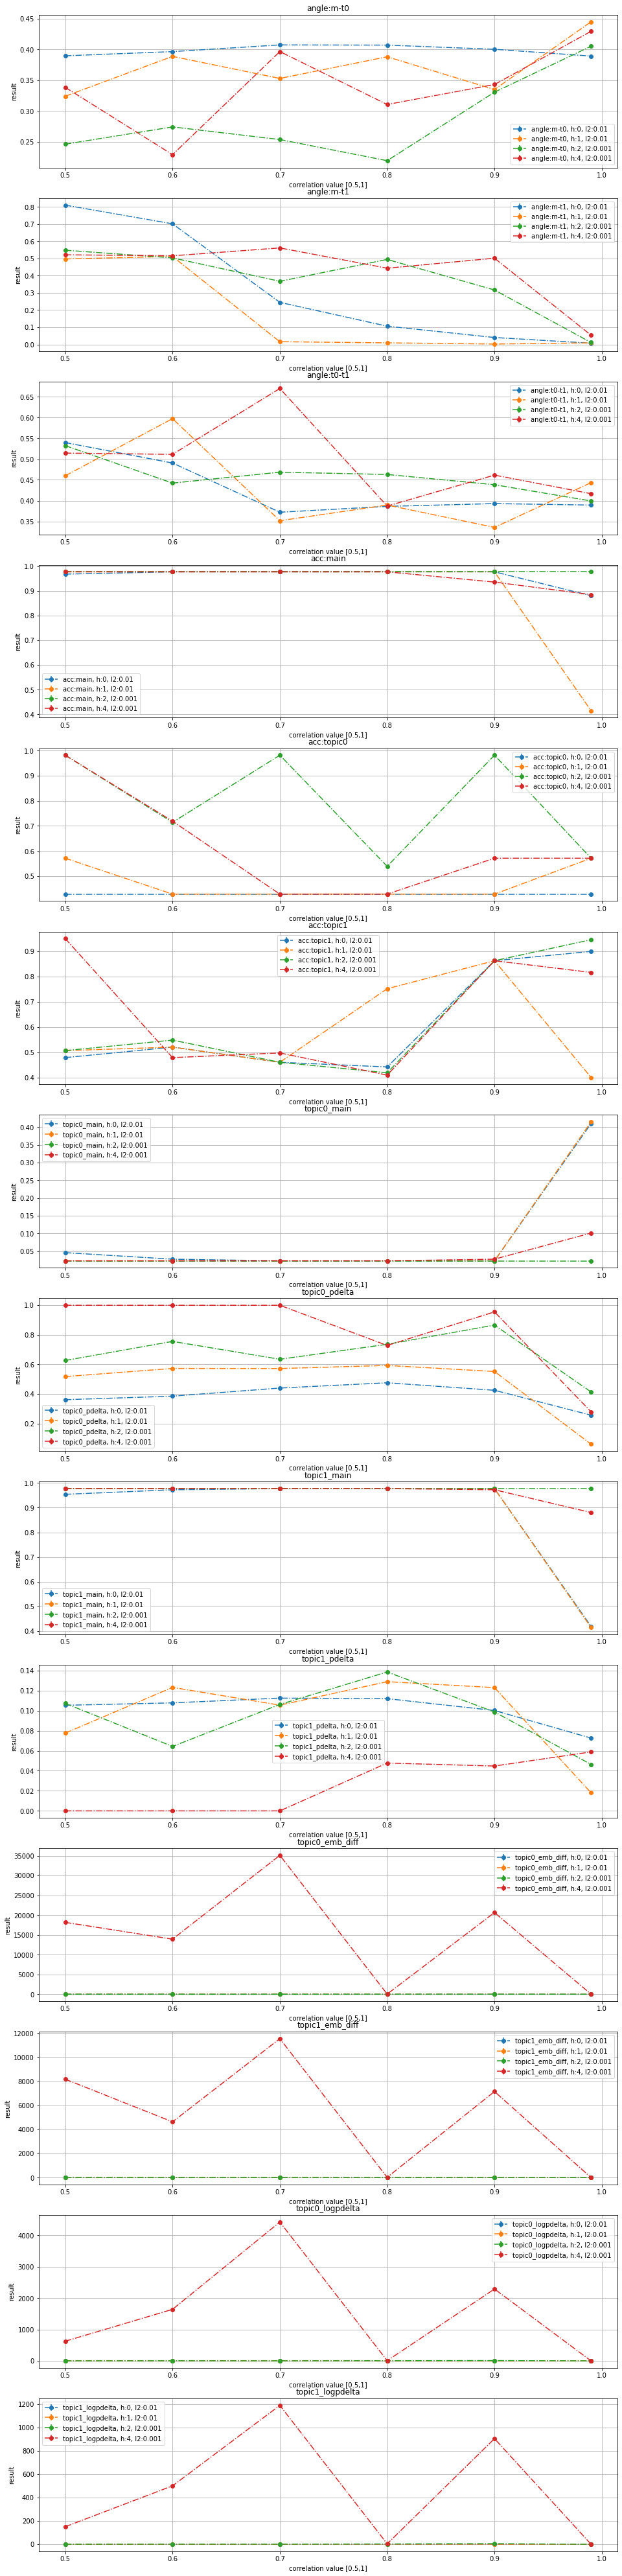

'\nHere we should choose h and lambda combination which is best for the model and see the trend.\n'

In [39]:
#Getting the result for different epochs
run_list=[0,]
plot_item_list = [
                    "angle:m-t0",
                    "angle:m-t1",
                    "angle:t0-t1",
                    "acc:main",
                    "acc:topic0",
                    "acc:topic1",
                    "topic0_main",
                    "topic0_pdelta",
                    "topic1_main",
                    "topic1_pdelta",
                    "topic0_emb_diff",
                    "topic1_emb_diff",
                    "topic0_logpdelta",
                    "topic1_logpdelta",
]


ax=None

#Other hyperparam
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99]
loss_type="linear_svm"
remmode="adversarial"
grstrength=1
advepoch=20
hretrain="no_warm_encoder"
mainmode="non_causal"
noise=0.025
hlayer=4
l2_lambda="0.001"
sample=500
mainepoch=1
for hlayer,l2_lambda in [(0,"0.01"),(1,"0.01"),(2,"0.001"),(4,"0.001")]:
    all_result_dict = get_all_result_dict(run_list=run_list,
                                          pval_list=pval_list,
                                          fname_pattern="nlp_logs/pt.rel.remmode({}).grstrength({}).advepoch({}).lt({}).l2({}).hretrain({}).mainmode({}).noise({}).hlayer({}).sample({}).mainepoch({}).p({}).run({})/probe_metric_list.json".format(
                                                                                  remmode,
                                                                                  grstrength,
                                                                                  advepoch,
                                                                                  loss_type,
                                                                                  l2_lambda,
                                                                                  hretrain,
                                                                                  mainmode,
                                                                                  noise,
                                                                                  hlayer,
                                                                                  sample,
                                                                                  mainepoch,
                                                                                  "{}",
                                                                                  "{}",
                                                            )
    )
#     print(all_result_dict)
    ax = plot_all_results(ax,pval_list,all_result_dict,plot_item_list,extra_label=", h:{}, l2:{}".format(hlayer,l2_lambda))


plt.show()
'''
Here we should choose h and lambda combination which is best for the model and see the trend.
'''